# ML Part Regression

In [1]:
from jupyter_core.paths import jupyter_path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb # Our ML library

In [3]:
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python/ML_Part/EOD")
df_compact = pd.read_csv("full_cleaned_dataframe_2023_optimized.csv")

In [4]:
#Let's take the top 5% as the test df
y_vals = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
n_days = [15,30,60,90,120,150]

test_dfs_list = []
train_dfs_list = []

for i, j in enumerate(y_vals):
    n = 5
    num_rows = int(len(df_compact[df_compact[j].notnull()])*(n/100))
    df_test = df_compact[df_compact[j].notnull()].iloc[:num_rows]
    df_train = df_compact[df_compact[j].notnull()].iloc[num_rows:]
    
    #Let's remove the data closest to the prediction date to make it close to a real world scenario
    max_date = df_train.date.max()
    max_date = datetime.strptime((df_train.date.max()), '%Y-%m-%d') - timedelta(days=n_days[i])
    max_date = max_date.strftime('%Y-%m-%d')
    df_train = df_train[df_train.date < max_date]
    
    #We can drop the date column as redundant now
    df_train.drop('date',axis = 1, inplace = True)
    df_test.drop('date',axis = 1, inplace = True)
    
    test_dfs_list.append(df_test)
    train_dfs_list.append(df_train)
    
    
    print(f"Train data size for {n_days[i]} is {df_train.shape[0]} rows")
    print(f"Test data size for {n_days[i]}  is {df_test.shape[0]} rows")

Train data size for 15 is 628181 rows
Test data size for 15  is 33347 rows
Train data size for 30 is 618381 rows
Test data size for 30  is 33079 rows
Train data size for 60 is 597313 rows
Test data size for 60  is 32544 rows
Train data size for 90 is 578766 rows
Test data size for 90  is 32007 rows
Train data size for 120 is 557329 rows
Test data size for 120  is 31470 rows
Train data size for 150 is 536932 rows
Test data size for 150  is 30934 rows


In [5]:
#For the simplicity of analysis we will work with one train dataframe but apply transformations to all the dataframes in the list
df_train = train_dfs_list[0]

cols_num = df_train.select_dtypes([np.number]).columns
cols_str = df_train.select_dtypes('object').columns

In [6]:
#df_compact_30 = df_compact.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train_gen, df_test_gen = df_train.copy(), df_test.copy()
df_train, df_test = train_dfs_list[1], test_dfs_list[1]

In [7]:
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)

In [8]:
#df_compact_30 = df_compact_30[df_compact_30['future_30dprice_change'].notna()]
df_train = df_train[df_train['future_30dprice_change'].notna()]
df_test = df_test[df_test['future_30dprice_change'].notna()]

In [9]:
#df_train, df_test = train_test_split(df_compact_30, test_size=0.2, random_state=42)

Light GBM can work with categoricl features 8x faster without using OneHotEncoder.
But transforming string to int is still required

In [10]:
#df_train.drop('stock', axis = 1, inplace = True)
#df_test.drop('stock', axis = 1, inplace = True)
df_train.drop(['stock','sector',"industry"], axis = 1, inplace = True)
df_test.drop(['stock','sector',"industry"], axis = 1, inplace = True)

In [11]:
#Creating the x, y variables 
y_train = df_train['future_30dprice_change']
y_test = df_test['future_30dprice_change']

x_train = df_train.drop('future_30dprice_change', axis = 1)
x_test = df_test.drop('future_30dprice_change', axis = 1)

### Creating a model

In [12]:
lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
#lgbm.fit(x_train, y_train, categorical_feature=['sector'])
lgbm.fit(x_train, y_train)

LGBMRegressor(n_estimators=50, n_jobs=5, random_state=42)

In [13]:
#predicting on test set
ypred=lgbm.predict(x_test)

In [14]:
#calculating accuracy
accuracy_30d = mae(y_test, ypred)
print(f"Accuracy of prediction:{accuracy_30d:0.4f}")

Accuracy of prediction:8.2410


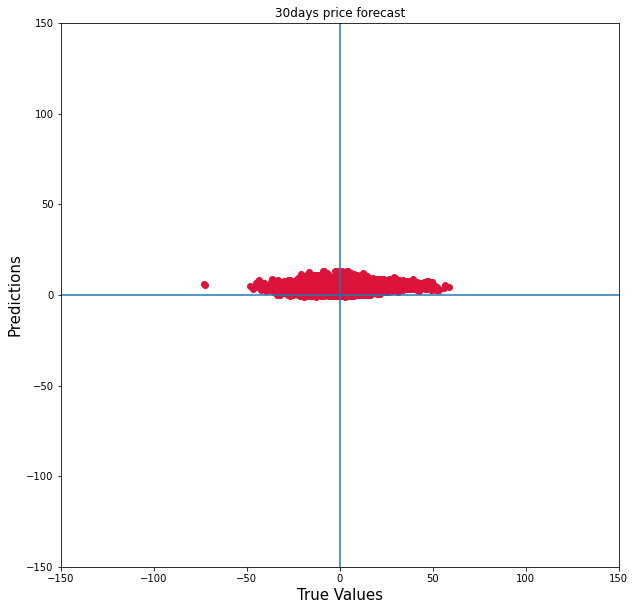

In [15]:
def true_predict_plot(y_val, ypred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(y_val, ypred, c='crimson')
    plt.yscale('linear')
    plt.xscale('linear')

    p1 = max(max(ypred), max(y_val))
    p2 = min(min(ypred), min(y_val))
    #plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.ylim(-150, 150)
    plt.xlim(-150, 150)
    #plt.axis('equal')
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.title(title)
    plt.show()
    
true_predict_plot(y_test, ypred,'30days price forecast')

In [16]:
def accuracy_df(y_test, ypred):
    df_y_vals = pd.DataFrame()
    df_y_vals["Real"] = y_test
    df_y_vals["Prediction"] = ypred
    df_y_vals["Delta"] = df_y_vals["Real"] - df_y_vals["Prediction"]
    df_y_vals["Correct"] = 0
    df_y_vals.loc[((df_y_vals['Real'] >0) & (df_y_vals['Prediction'] >0)) | ((df_y_vals['Real'] <0) & (df_y_vals['Prediction'] <0)),'Correct'] = 1

    true_false_values = df_y_vals.groupby("Correct").count().Real.to_frame()

    true_false_values["Value, %"] = (true_false_values['Real'] / true_false_values['Real'].sum()) * 100
    true_false_values["Value, %"] = true_false_values["Value, %"].round(2)
    print(true_false_values)

    print("\nTotal cases evaluated:",true_false_values.Real.sum())
    return true_false_values

acc_percent_30d = accuracy_df(y_test, ypred)
acc_percent_30d = acc_percent_30d["Value, %"][1]

          Real  Value, %
Correct                 
0        14205     42.94
1        18874     57.06

Total cases evaluated: 33079


We got 57% acuracy for the 500 companies. That is not bad. Let's check if we get better results with the other prediction periods.

### Let's see how we perform with the other forecast periods

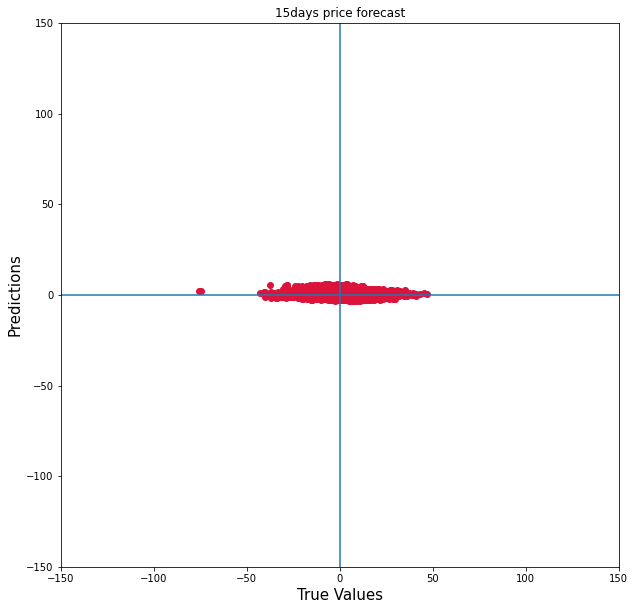

Accuracy of prediction:6.0202


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        17061     51.16
1        16286     48.84

Total cases evaluated: 33347
    Value                     Feature   Value, %
40    220                    industry  14.666667
39    181           days_after_crisis  12.066667
38    114                    VIX_high   7.600000
37    103             Fed_Balance_YoY   6.866667
36     78           EPS_1Y_exp_Change   5.200000
35     73                    10YB_MoM   4.866667
34     72                    10YB_YoY   4.800000
32     67             10Y_Val_to_30MA   4.466667
33     67                     VIX_WoW   4.466667
31     65             Fed_Balance_MoM   4.333333
30     59                     10YBond   3.933333
29     57            10Y_Val_to_200MA   3.800000
28     52                     VIX_MoM   3.466667
27     49           10YB_200MA_Vector   3.266667
26     28                     VIX_DoD   1.866667
25     22  d

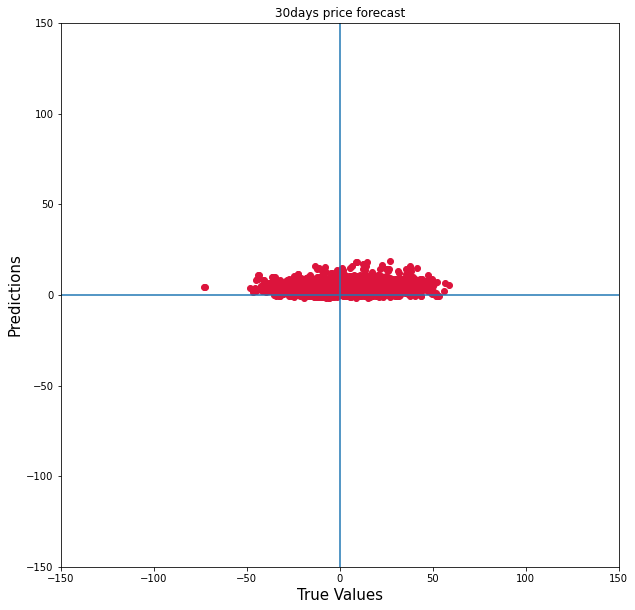

Accuracy of prediction:8.3982


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        14219     42.98
1        18860     57.02

Total cases evaluated: 33079
    Value                     Feature   Value, %
40    271                    industry  18.066667
39    181           days_after_crisis  12.066667
38    110             Fed_Balance_YoY   7.333333
37     99                    VIX_high   6.600000
36     99           EPS_1Y_exp_Change   6.600000
35     67                    10YB_YoY   4.466667
34     54             Fed_Balance_MoM   3.600000
33     54           10YB_200MA_Vector   3.600000
32     41                     VIX_MoM   2.733333
31     41            10Y_Val_to_200MA   2.733333
30     38                     10YBond   2.533333
29     35                    10YB_MoM   2.333333
28     32             10Y_Val_to_30MA   2.133333
27     29                      YoY_PE   1.933333
26     28       EPS_1Y_exp_Change_QoQ   1.866667
25     27   

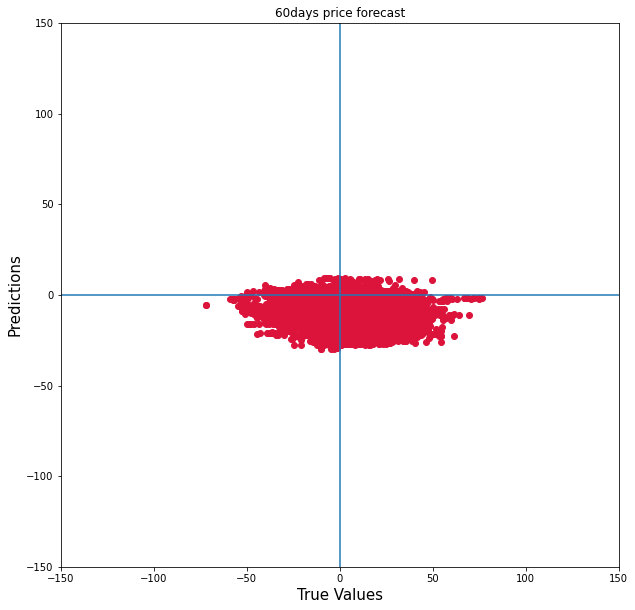

Accuracy of prediction:15.2493


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        18887     58.04
1        13657     41.96

Total cases evaluated: 32544
    Value                     Feature   Value, %
40    312                    industry  20.800000
39    175           days_after_crisis  11.666667
38    114           EPS_1Y_exp_Change   7.600000
37    113             Fed_Balance_YoY   7.533333
36     60       EPS_1Y_exp_Change_QoQ   4.000000
35     47                    VIX_high   3.133333
34     47                    10YB_YoY   3.133333
33     40                          PE   2.666667
32     37                     10YBond   2.466667
31     33                          ES   2.200000
30     32              EPS_YoY_Growth   2.133333
29     31           10YB_200MA_Vector   2.066667
28     30                         ROE   2.000000
27     28                      YoY_PE   1.866667
26     28             Fed_Balance_MoM   1.866667
25     27  

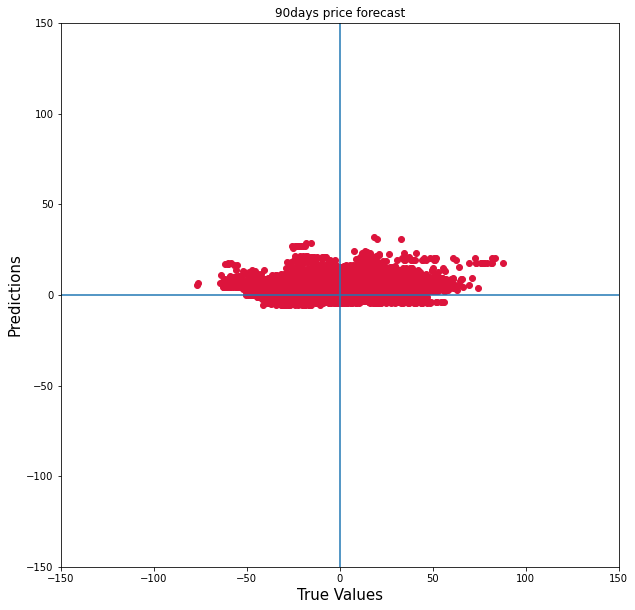

Accuracy of prediction:12.1276


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        14676     45.85
1        17331     54.15

Total cases evaluated: 32007
    Value                     Feature   Value, %
40    313                    industry  20.866667
39    158           days_after_crisis  10.533333
38    139           EPS_1Y_exp_Change   9.266667
37     86             Fed_Balance_YoY   5.733333
36     49       EPS_1Y_exp_Change_QoQ   3.266667
35     48                    10YB_YoY   3.200000
34     43                          PE   2.866667
32     38              EPS_YoY_Growth   2.533333
33     38                         ROE   2.533333
31     35                 PEG_Forward   2.333333
30     32                    VIX_high   2.133333
29     32                          DE   2.133333
28     31                      YoY_DY   2.066667
27     31                          ES   2.066667
26     30                    YoY_PEGF   2.000000
25     28  

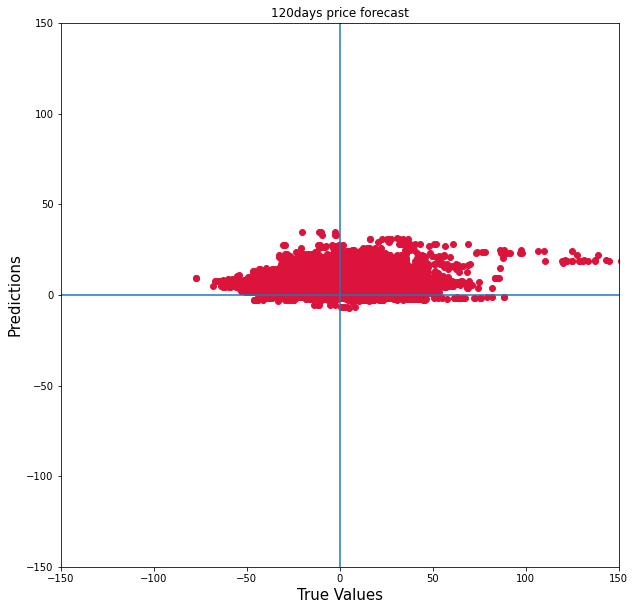

Accuracy of prediction:14.1782


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        15325      48.7
1        16145      51.3

Total cases evaluated: 31470
    Value                     Feature   Value, %
40    323                    industry  21.533333
39    155           days_after_crisis  10.333333
38    118           EPS_1Y_exp_Change   7.866667
37     70       EPS_1Y_exp_Change_QoQ   4.666667
36     64             Fed_Balance_YoY   4.266667
35     47              EPS_YoY_Growth   3.133333
34     45                          PE   3.000000
33     42                    VIX_high   2.800000
32     39                         ROE   2.600000
30     36                    10YB_YoY   2.400000
31     36                          CR   2.400000
29     35                          ES   2.333333
28     33                          GM   2.200000
27     33            10Y_Val_to_200MA   2.200000
26     32                 PEG_Forward   2.133333
25     31  

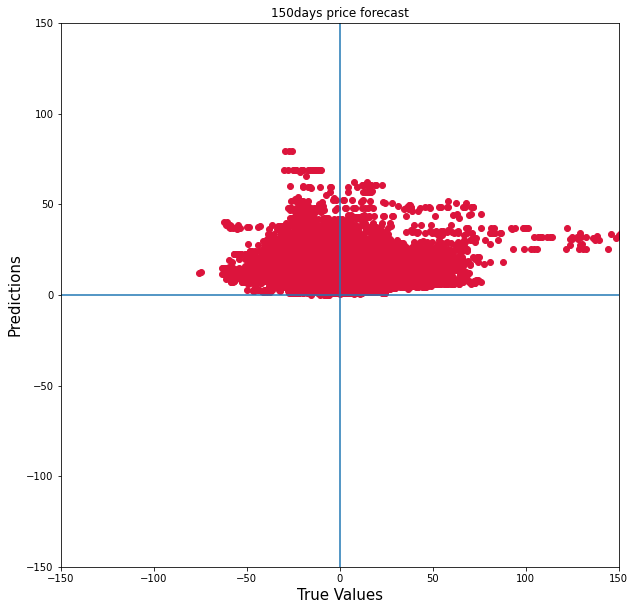

Accuracy of prediction:18.5094


Increase or decrease predicted correctly:
          Real  Value, %
Correct                 
0        14528     46.96
1        16406     53.04

Total cases evaluated: 30934
    Value                     Feature   Value, %
40    312                    industry  20.800000
39    128           EPS_1Y_exp_Change   8.533333
38    123           days_after_crisis   8.200000
37     77       EPS_1Y_exp_Change_QoQ   5.133333
36     63             Fed_Balance_YoY   4.200000
35     53              EPS_YoY_Growth   3.533333
34     44                          GM   2.933333
33     43                          PE   2.866667
32     41                    VIX_high   2.733333
31     39                          CR   2.600000
30     38                          DY   2.533333
29     37                      YoY_DY   2.466667
28     37                          DE   2.466667
27     36                         ROE   2.400000
26     35                      YoY_GM   2.333333
25     33  

In [17]:
targets_all =["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
periods = ["15days", "30days", "60days", "90days", "120days", "150days"]

MAEs = []
acc_percent_list = []
feature_importances = []
list_of_regression_models = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    
    df_train, df_test = train_dfs_list[j], test_dfs_list[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1).copy()
    df_test = df_test.drop(remove_redundant_list,axis = 1).copy()
    df_train = df_train[df_train[i].notna()]
    df_test = df_test[df_test[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)

    #df_train.drop(["stock"], axis = 1, inplace = True)
    #df_test.drop(["stock"], axis = 1, inplace = True)
    df_train.drop(["stock","sector"], axis = 1, inplace = True)
    df_test.drop(["stock","sector"], axis = 1, inplace = True)

    le = LabelEncoder()
    #le.fit(df_train["sector"])
    #df_train["sector"] = le.transform(df_train["sector"])
    #df_test["sector"] = le.transform(df_test["sector"])
    le.fit(df_train["industry"])
    df_train["industry"] = le.transform(df_train["industry"])
    df_test["industry"] = le.transform(df_test["industry"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
    list_of_regression_models.append(lgbm)
    #lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    lgbm.fit(x_train, y_train, categorical_feature=['industry'])

    #predicting on test set
    ypred=lgbm.predict(x_test)

    true_predict_plot(y_test, ypred, periods[j] +' price forecast')

    #calculating accuracy
    from sklearn.metrics import mean_absolute_error as mae
    accuracy = mae(y_test, ypred)
    MAEs.append(accuracy)
    print(f"Accuracy of prediction:{accuracy:0.4f}")

    print("\n\nIncrease or decrease predicted correctly:")
    acc_percent = accuracy_df(y_test, ypred)
    acc_percent = acc_percent["Value, %"][1]
    acc_percent_list.append(acc_percent)
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False))
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Result summarization

In [18]:
MAEs = [round(x*100,2) for x in MAEs]

index = [15,30,60,90,120,150]
accuracy_compare_dt = {"Absolute Error":MAEs,"Correctly Predicted Price Direction":acc_percent_list}
accuracy_compare_df= pd.DataFrame(accuracy_compare_dt, index=index)
accuracy_compare_df.index.name = "Forecasted Period, days"

print(accuracy_compare_df)

                         Absolute Error  Correctly Predicted Price Direction
Forecasted Period, days                                                     
15                               602.02                                48.84
30                               839.82                                57.02
60                              1524.93                                41.96
90                              1212.76                                54.15
120                             1417.82                                51.30
150                             1850.94                                53.04


We see that error is above 50% that states that the model performance is poor.

In [19]:
all_features_evolution = []
for i, j in enumerate(feature_importances):
    features_sorted = feature_importances[i].sort_values(by='Value, %', ascending=False)["Feature"].tolist()
    all_features_evolution.append(features_sorted)

features_evolution = pd.DataFrame(all_features_evolution, index = index)
accuracy_compare_df.index.name = "Forecasted Period, days"
features_evolution

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
15,industry,days_after_crisis,VIX_high,Fed_Balance_YoY,EPS_1Y_exp_Change,10YB_MoM,10YB_YoY,10Y_Val_to_30MA,VIX_WoW,Fed_Balance_MoM,...,YoY_PEGB,YoY_GM,YoY_CR,DPR,GM,CR,EPS_surprise,YoY_DPR,YoY_Piotroski,Piotroski_Score
30,industry,days_after_crisis,Fed_Balance_YoY,VIX_high,EPS_1Y_exp_Change,10YB_YoY,Fed_Balance_MoM,10YB_200MA_Vector,VIX_MoM,10Y_Val_to_200MA,...,DE,YoY_GM,GM,PEG_Backwards,EPS_QoQ_frcst_diff,DPR,EPS_surprise,YoY_DPR,YoY_PEGB,Piotroski_Score
60,industry,days_after_crisis,EPS_1Y_exp_Change,Fed_Balance_YoY,EPS_1Y_exp_Change_QoQ,VIX_high,10YB_YoY,PE,10YBond,ES,...,10YB_MoM,YoY_PEGB,GM,YoY_DPR,PEG_Backwards,days_after_earnings_report,Piotroski_Score,VIX_WoW,VIX_DoD,EPS_QoQ_frcst_diff
90,industry,days_after_crisis,EPS_1Y_exp_Change,Fed_Balance_YoY,EPS_1Y_exp_Change_QoQ,10YB_YoY,PE,EPS_YoY_Growth,ROE,PEG_Forward,...,VIX_MoM,YoY_DPR,10Y_Val_to_30MA,Piotroski_Score,YoY_PEGB,EPS_QoQ_frcst_diff,10YB_MoM,days_after_earnings_report,VIX_WoW,VIX_DoD
120,industry,days_after_crisis,EPS_1Y_exp_Change,EPS_1Y_exp_Change_QoQ,Fed_Balance_YoY,EPS_YoY_Growth,PE,VIX_high,ROE,10YB_YoY,...,VIX_MoM,PEG_Backwards,YoY_PEGB,Piotroski_Score,10YB_MoM,days_after_earnings_report,10Y_Val_to_30MA,VIX_WoW,VIX_DoD,EPS_QoQ_frcst_diff
150,industry,EPS_1Y_exp_Change,days_after_crisis,EPS_1Y_exp_Change_QoQ,Fed_Balance_YoY,EPS_YoY_Growth,GM,PE,VIX_high,CR,...,VIX_MoM,PEG_Backwards,Piotroski_Score,YoY_PEGB,10YB_MoM,days_after_earnings_report,EPS_QoQ_frcst_diff,VIX_WoW,VIX_DoD,10Y_Val_to_30MA


As we see our model finds external factors as bonds rate and fear level as the best predictors even for the long term forecast. 
Dividends change timing also play it's role as the industry compny works in.
My expectation was to see PE ratio in the top 5, but it seems it doesn't play a big role. 

## Changing the perspective